# **Cyfrowe Przetwarzanie Sygnałów**

**Laboratorium nr 9 Filtry adaptacyjne**

prof. dr hab. inż. Tomasz Zieliński, dr inż. Jarosław Bułat

Python/colab: Kacper Bojanowski

---

## **1. Odszumianie (2+0.25 pkt)**

Jednym z przykładów zastosowań filtrów adaptacyjnych jest układ odszumiający (ANC – Adaptive Noise Cancelling), wykorzystujący w sposób adaptacyjny zasadę liniowej predykcji. Filtr pozostawia w sygnale tylko składowe, których następne próbki można przewidzieć na podstawie próbek poprzednich – czyli składowe sinusoidalne/deterministyczne (następną próbkę sinusoidy można obliczyć na podstawie dwóch poprzednich próbek).  Natomiast inne, losowe (szumowe) – marginalizuje. Innymi słowy filtr adaptacyjny ,,dostraja'' się do dających się przewidzieć składowych deterministycznych. 
Z powyższego faktu wynika, że metoda ta nadaje się do poprawiania jakości sygnałów złożonych z wielu harmonicznych, takich jak sygnał mowy.
W układzie ANC, sygnałem odniesienia d jest zaszumiony sygnał, natomiast sygnałem  x ten sam sygnał tylko opóźniony o jedną próbkę. Implementację takiego układu dla kryterium (N)LMS, bez zainicjalizowanych parametrów przedstawiono poniżej.






In [ ]:
import numpy as np

dref = ???                                              # sygnał ”czysty” do porównania

target_snr_db = 20
t = np.linspace(1, 100, 1000)
x_volts = 10*np.sin(t/(2*np.pi))
x_watts = x_volts ** 2
sig_avg_watts = np.mean(x_watts)
sig_avg_db = 10 * np.log10(sig_avg_watts)
noise_avg_db = sig_avg_db - target_snr_db
noise_avg_watts = 10 ** (noise_avg_db / 10)

d = np.random.normal(dref, np.sqrt(noise_avg_watts), len(x_watts)) # WE: sygnał  odniesienia dla sygnału x
x = np.append(d[0], d[:-1])                             #  WE: sygnał filtrowany, teraz opóźniony d
M = ???                                                 # długość filtru
mi = ???                                                #  współczynnik szybkości adaptacji

# sygnały wyjściowe z filtra
y = []
e = []
bx = np.zeros(M,1)                                      # bufor na próbki wejściowe x
h = np.zeros(M,1)                                       # początkowe (puste) wagi filtru

for n in range(1,x.length):
    bx[0] = np.insert(bx[:-1], [0], x[n])               # pobierz nową próbkę x[n] do bufora
    y[n] = h.transpose() * bx                           # oblicz y[n] = sum( x .* bx) – filtr FIR
    e[n] = d[n] - y[n]                                  # oblicz e[n]
    h = h + mi * e[n] * bx                              # LMS
    # h = h + mi * e[n] * bx /(bx.transpose() * bx)     # NLMS

Wygeneruj sygnał złożony z dwóch harmonicznych o następujących parametrach:

* częstotliwość próbkowania: $f_s$= 8000 Hz, 
* czas trwania $t$= 1 s,
* amplitudy i częstotliwości odpowiednio: $A_1$= -0.5, $f_1$= 34.2 Hz, $A_2$= 1, $f_2$= 115.5 Hz.

Do sygnału dodaj szum AWGN o mocy 10, 20 i 40 dB. Następnie dobierz tak parametry filtru adaptacyjnego aby jednym zestawem parametrów odszumić jak najlepiej wszystkie 3 wersje sygnału. Jakość odszumiania wyznacz za pomocą wskaźnika SNR, definiowanego jako iloraz mocy sygnału i mocy szumu (zakłóceń, czyli różnicy pomiędzy sygnałem oryginalnym $dref(n)$ przed dodaniem szumu a sygnałem po odszumieniu $y(n)$):

$$
{SNR}_{dB}=10log_{10}\frac{\frac{1}{N}\sum_{n=0}^{N}dref(n)^2}{\frac{1}{N}\sum_{n=0}^{N}(dref(n)−y(n))^2}
$$

gdzie $N$ to liczba próbek sygnału.

Wyświetl na jednym wykresie sygnał oryginalny, zaszumiony oraz odszumiony.


**Opcjonalnie** (+0.25 pkt) Wczytaj sygnał mowy z pliku `mowa8000.wav`, poddaj go zaszumianiu jak wcześniej i spróbuj znaleźć najlepsze parametry dla filtru adaptacyjnego. Jakość odszumiania wyznacz odsłuchując próbkę mowy. Zwróć uwagę na różnicę w śledzeniu głosek dźwięcznych i bezdźwięcznych. Podczas obliczeń wyświetlaj odpowiedź amplitudowo-częstotliwościową filtru h oraz widmo gęstości mocy fragmentu ostatnio analizowanego sygnału. Dla głosek dźwięcznych, widma te powinny być zbliżone.

Dodatkowo, zastosuj algorytm adaptacji RLS do powyższych przykładów [PWN, rozdz. 7]


In [ ]:
"""
Opcjonalnie  (0.25 pkt)
"""
import soundfile as sf
import gdown

# wczytanie pliku
# pliki do pobrania na poczatku laboratorium
gdown.download('https://drive.google.com/uc?id=1xoro-rWT3D7lpfzXd_X9LScFoLzf2XOP', 'mowa8000.wav')
dref, fs = sf.read('mowa8000.wav')


## **2a. Identyfikacja obiektu (2 pkt)**
### **alternatywnie z 2b**
Następnym interesującym nas zastosowaniem jest wykorzystanie filtru adaptacyjnego jako układu do identyfikacji obiektu, np.: identyfikacji odpowiedzi impulsowej kanału komunikacyjnego lub akustycznej odpowiedzi impulsowej pomieszczenia, definiującej pogłos w tym pomieszczeniu.

W takim układzie, sygnałem wejściowym `x` są próbki sygnału oryginalnego (zazwyczaj sekwencja treningowa), natomiast sygnałem odniesienia `d` są próbki po przejściu przez obiekt (często zaszumione), czyli zniekształcone w stosunku do oryginału. Wynikiem adaptacji są wartości wag h filtru, równe odpowiedzi impulsowej układu. Można ich użyć do analizy lub kompensacji wpływu obiektu na sygnał. I tak, typowa sekwencja danych (ramka) w transmisji bezprzewodowej składa się z pilota oraz danych. Pilot jest znaną sekwencją treningową, na której jest uczony korektor, wykorzystywany później do poprawy zniekształconych sekwencji, zawierających dane.

Jako sygnał wejściowy wykorzystaj próbkę mowy z pliku `mowa8000.wav`. Sygnałem odniesienia niech będzie próbka mowy przefiltrowana filtrem o następującej odpowiedzi impulsowej.


$$
h_{i}=
\begin{cases}
  0.8 & i=255 \\ −0.5 & i=120 \\0.1 & i=30 \\0 & i\neq255,120,30
 \end{cases}  \text{dla } i=0,1,2,...,255
 $$

Porównaj estymację odpowiedzi impulsowej uzyskaną z filtru (jego wagi  $\bar{h}$) z odpowiedzią
rzeczywistą, zdefiniowaną powyższej. Dobierz parametry filtru adaptacyjnego tak, aby uzyskać jak
najbardziej podobne sygnał. Zauważ, że estymatę odpowiedzi impulsowej obiektu obliczyłeś za
pomocą sygnału ,,użytecznego'', a nie sekwencji treningowej. Powtórz doświadczenie wykorzystując
szum biały, a nie sygnał mowy, jako sekwencję treningową.



In [ ]:
"""
Zadanie 2a. Identyfikacja obiektu (2 pkt)
"""
import gdown
import soundfile as sf

# wczytanie pliku mowa8000
# pliki do pobrania na poczatku laboratorium
gdown.download('https://drive.google.com/uc?id=1xoro-rWT3D7lpfzXd_X9LScFoLzf2XOP', 'mowa8000.wav')
dref, fs = sf.read('mowa8000.wav')


## **2b. Kasowanie echa (2 pkt)**
### **alternatywnie z 2a**
Na poniższym obrazku pokazano instalację głośnomówiącą. Załóżmy, że użytkownicy są połączeni ze sobą dwukierunkowym zestawem telekonferencyjnym oraz że mówią równocześnie. W takim przypadku mikrofon użytkownika *A* rejestruje (i wysyła do użytkownika *B*) głos użytkownika *A* ($S_A$) oraz głos użytkownika *B* ($S_B$), transmitowany przez głośnik znajdujący się w pomieszczeniu *A*. Dodatkowo, sygnał $S_B$ jest zmodyfikowany nieznaną transmitancją *G*,  czyli funkcją przejścia układu głośnik-pokój-mikrofon.

> 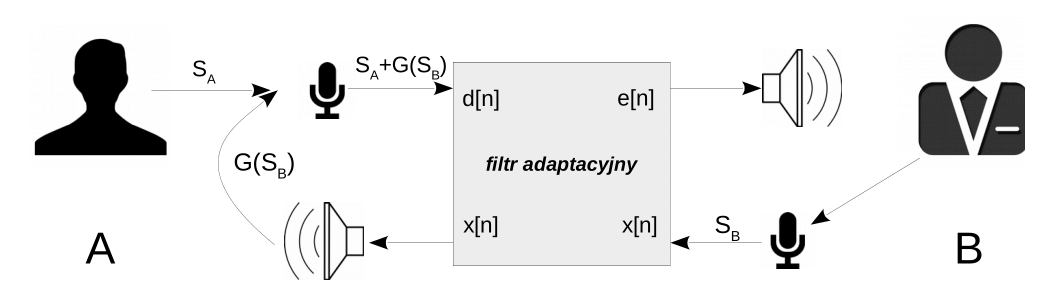

Układ adaptacyjny działający w części *A*, zna sygnał $S_B$ (odbiera go od *B*) oraz sygnał $S_A+G(S_B)$, który jest rejestrowany przez mikrofon.

Jeżeli sygnał $S_A+G(S_B)$ potraktujemy jako zaszumiony sygnał odniesienia *d*, natomiast $S_B$  jako sygnał wejściowy $x$, to na wyjściu $e$ filtru adaptacyjnego otrzymamy odszumiony sygnał $S_A$. Dzięki temu układ nadajnika *A* transmituje do *B* sygnał pozbawiony echa. Wykonaj i przetestuj układ kasowania echa dysponując następującymi sygnałami:

* $S_A$ : `mowa_1.wav`, sygnał do porównania, w rzeczywistości sygnał $S_A$  jest niemożliwy do zarejestrowania,
* $S_B$ : `mowa_2.wav`,
* $S_A+G(S_B)$: `mowa_3.wav`.










In [ ]:
"""
Zadanie 2b. Kasowanie echa (2 pkt)
"""
import soundfile as sf
import gdown

# wczytywanie sygnalow mowy z plikow mowa_1,2,3.wav
# pliki do pobrania na poczatku laboratorium
gdown.download('https://drive.google.com/uc?id=1uxk2jopf8boFE7nx8CpsH0YCxbNsE_1i', 'mowa_1.wav')
gdown.download('https://drive.google.com/uc?id=1BNEC6ZiAPSblolmnmpv6wvlR4PsVNbF8', 'mowa_2.wav')
gdown.download('https://drive.google.com/uc?id=1xBJNO3PdbEZlGaINVoTd4-tCaB1Ac-j3', 'mowa_3.wav')
sa, fs1 = sf.read('mowa_1.wav')         # glos osoby A
sb, fs2 = sf.read('mowa_2.wav')         # glos osoby B
sag, fs3 = sf.read('mowa_3.wav')        # glos osoby A zaszumiony G(SB)


## **3. Pętla PLL (1+0.5 pkt)**

Zanim zastosujesz PLL w praktyce, sprawdź czy działa na syntetycznym sygnale. W tym celu:


1.   Wygeneruj sygnał udający pilota 19 kHz o stałym przesunięciu fazowym i sprawdź, czy adaptacyjny oscylator się do niego dostroi.

2.   Wygeneruj sygnał j.w. tylko niech częstotliwość pilota dodatkowo wolno się zmienia sinusoidalnie: ±10 Hz ($d_f$=10 Hz) jeden raz na 10 sekund ($f_m$=0.1 Hz). Sprawdź czy adaptacyjny oscylator dostroi się do pilota.

3. Sprawdź szybkość zbieżności pętli PLL. W tym celu do sygnału z pkt. 1 dodaj szum AWGN o mocy: 0, 5, 10 i 20 dB. Znając sygnał oczekiwany (wzorcowy), określ po ilu próbkach oscylator dostroił się do sygnału.

Poniżej przedstawiono fragment programu realizującego cyfrową pętlę PLL. Sygnałem wejściowym jest wektor `p`. Przykładowy sygnał harmoniczny o 3 razy większej częstotliwości (trzecia harmoniczna) niż śledzony sygnał został wygenerowany w zmiennej `c57`.


In [ ]:
import numpy as np

# Petla PLL z filtrem typu IIR do odtworzenia częstotliwości i fazy pilota [7]
# i na tej podstawie sygnałów nośnych: symboli c1, stereo c38 i danych RDS c57
freq = 2 * np.pi * fpilot / fs
theta = np.zeros(len(p) + 1)
alpha = 0.001
beta = (alpha ** 2) / 4

for n in range(len(p)):
    perr = -p[n] * np.sin(theta[n])
    theta[n + 1] = theta[n] + freq + alpha * perr
    freq = freq + beta * perr

c57 = []
c57[:1] = np.cos(3 * theta[1:])    # nosna 57 kHz

**Opcjonalnie** (+0.5 pkt): Do dekodowania stereofonicznego radia FM należy zrekonstruować sygnały L+R oraz L-R (patrz laboratorium 07), a następnie dodać je i odjąć od siebie. Nawet dla niewielkich przesunięć fazowych pomiędzy sygnałami L+R i L-R, dekodowanie sygnału stereo nie powiedzie się!

Dlatego też oprócz kompensacji opóźnień wprowadzanych przez filtry FIR należy również dokładnie odtworzyć częstotliwość oraz fazę sygnału nośnego dla komponentu L-R w celu przesunięcia go do pasma podstawowego. Wykorzystaj przykład z pliku `fm_dekoder_stereo.m` dekodujący sygnał stereo z syntetycznych danych zamieszczonych w laboratorium 07.


4.   Wygeneruj sygnał pilota `c38` o częstotliwości 38 kHz (podwojona wartość pilota 19 kHz znajdującego się w sygnale hybrydowym) bez pętli fazowej. Sprawdź separację pomiędzy kanałem L i R.

5.   Sprawdź separację kanałów dla częstotliwość pilota na 38001 Hz. Następnie wróć do 38 kHz, zmień fazę pilota i ponownie zweryfikuje separację kanału

6. Zastosuj adaptycyjną pętlę synchronizacji z sygnałem pilota `c19` (19 kHz) i wykorzystaj wynik jej pracy do wygenerowania poprawnego sygnału nośnego `c38`. (38 kHz), czyli sygnału o podwojonej częstotliwości. Sprawdź separację kanałów dla tej wersji dekodera stereo.

7. Zastosuj program bez pętli PLL i z pętlą PLL do sygnału radiowego, w którym pilot w nadajniku: a) opóźnia się o stały kąt fazowy, b) odstroił się od 19kHz, c) suma a) + b). W tym celu spróbuj odtworzyć nagrania FM: `stereo_fm_broken_pilot_a.mat`, `stereo_fm_broken_pilot_b.mat`, `stereo_fm_broken_pilot_c.mat` (sekwencje zawierają takie same dane jak `stereo_samples_fs1000kHz_LR_IQ.mat`). Wyświetl spektrogram sygnału hybrydowego dla wersji ,,b''. Sprawdź czy widoczne są zmiany częstotliwości pilota.

Opis i wyprowadzenie algorytmu synchronizacji z pilotem jest w dokumencie „`FM_SynchoPilot.pdf`”.

In [ ]:
"""
Opcjonalnie  (0.5 pkt)
"""

import gdown
import scipy.io


'''
W celu wczytania pliku na platformie Collab konieczna była zamiana pliku .mat 
na wersje .7
'''
gdown.download('https://drive.google.com/uc?id=1MqquX-bigMSiUm1y8ZTh9pzbK7mx4dHD', 'stereo_fm_broken_pilot_b_7.mat') 
data = scipy.io.loadmat('stereo_fm_broken_pilot_b_7.mat')
